In [1]:
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable

# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [2]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
df = pd.read_sql('select * from results.gru_meta', conn)

/var/folders/vt/5wzq72vd2mj_qqq_fwp77h_40000gq/T/ipykernel_74674/1986280008.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('select * from results.gru_meta', conn)


In [5]:
df.set_index('newsite', inplace=True)

In [6]:
# run a regression analysis
import statsmodels.api as sm
from statsmodels.formula.api import ols

#import std scaler
from sklearn.preprocessing import StandardScaler

In [7]:
df.columns

Index(['GRU', 'avg_monthly_electricity_bill', 'no_resident_adults_16_plus',
       'no_resident_adults_over_65', 'no_resident_children_under_16',
       'weekday_morning_evening', 'someone_home_all_day',
       'continuous_electricity_supply', 'household_annual_income',
       'property_type', 'approx_year_of_build', 'has_Fridge', 'has_Freezer',
       'has_Microwave', 'has_Oven', 'has_Toaster', 'has_Kettle',
       'has_Dishwasher', 'has_Washing Machine', 'has_TV',
       'has_Digital / Sky box / Apple TV', 'has_Game Console', 'has_Stereo',
       'has_PC / Laptop', 'has_Tablet', 'has_Smart Phone', 'has_Hair Dryer',
       'has_Hair Straighteners', 'has_Vaccuum', 'has_fish tank and pond pump',
       'electric_vehicle_owned', 'dwelling_type_1', 'dwelling_type_2',
       'floor_area', 'heating_fuel', 'hot_water', 'besskwh', 'besskw', 'pvkw'],
      dtype='object')

In [8]:
# turn categorical data into dummy variables
dtypes = df.dtypes
mask = dtypes == np.object
categorical_columns = dtypes[mask].index
df_encoded = pd.get_dummies(df, columns=categorical_columns)

/var/folders/vt/5wzq72vd2mj_qqq_fwp77h_40000gq/T/ipykernel_74674/1445940484.py:3: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = dtypes == np.object


In [9]:
# scale the data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_encoded), columns=df_encoded.columns)

<Axes: >

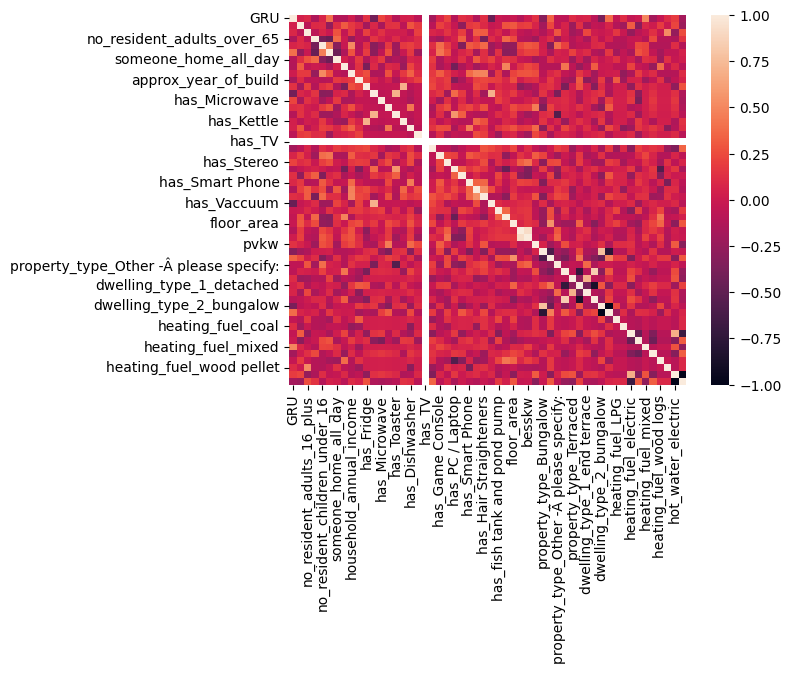

In [10]:
# check correlation heatmap
import seaborn as sns
sns.heatmap(df_scaled.corr())

In [11]:
#check highest and lowest correlations with lstm
cor = df_scaled.corr()['GRU'].sort_values()

In [12]:
# filter columns to get the highest correlated columns
cols = cor[(cor > 0.2) | (cor < -0.2)].index

In [13]:
cols

Index(['has_Vaccuum', 'has_Freezer', 'dwelling_type_2_bungalow',
       'property_type_Bungalow', 'has_Stereo', 'has_Microwave',
       'property_type_Detached', 'dwelling_type_2_house',
       'weekday_morning_evening', 'heating_fuel_mixed', 'GRU'],
      dtype='object')

In [14]:
df_scaled = df_scaled[cols]

In [15]:
# check feature importance with xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df_scaled.drop('GRU', axis=1)
y = df_scaled['GRU']

# create a random search cross validation using all the data
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint


param_grid = {
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 0.5),
    'n_estimators': randint(100, 1000),
}

xgb = XGBRegressor()

search = RandomizedSearchCV(xgb, param_grid, n_iter=100, scoring='neg_mean_squared_error', n_jobs=-1, cv=5, verbose=1, random_state=42)
search.fit(X, y)

print(search.best_params_)

# check feature importance
xgb = XGBRegressor(**search.best_params_)
xgb.fit(X, y)




Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'colsample_bytree': 0.5060772373449082, 'gamma': 0.4849394133538195, 'learning_rate': 0.022947973585172834, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 312, 'subsample': 0.9964823980596502}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5060772373449082, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.4849394133538195,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.022947973585172834,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=6, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=312, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [16]:
# get the golumns of the features that are greater thah 0
features = X.columns[xgb.feature_importances_ > 0]

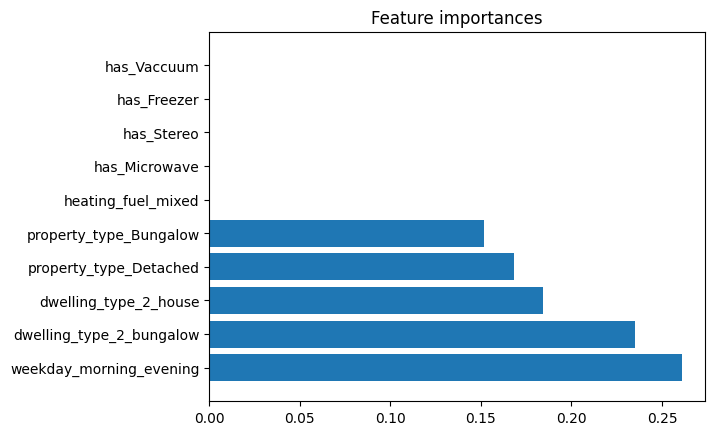

In [17]:
# plot the feature importance sorted by importance
importances = xgb.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), np.array(X.columns)[indices])
plt.ylim([-1, X.shape[1]])
plt.show()

In [18]:
# run a regression analysis
import statsmodels.api as sm
from statsmodels.formula.api import ols

# fill na with the mean of each column


XX = sm.add_constant(X[features].fillna(X[features].mean()))
model = sm.OLS(y, XX)
results = model.fit()

In [19]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:                OLS                Adj. R-squared:       0.268   
Dependent Variable:   GRU                AIC:                  109.2683
Date:                 2024-04-26 12:17   BIC:                  117.8362
No. Observations:     41                 Log-Likelihood:       -49.634 
Df Model:             4                  F-statistic:          4.653   
Df Residuals:         36                 Prob (F-statistic):   0.00394 
R-squared:            0.341              Scale:                0.75078 
-----------------------------------------------------------------------
                          Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-----------------------------------------------------------------------
const                     0.0000   0.1353  0.0000 1.0000 -0.2744 0.2744
dwelling_type_2_bungalow -0.0557   0.1139 -0.4892 0.6277 -0.2868 0.1753
property_type_Bungalow   -0.0599   0.2435 -0.2458 0.8072 -0.5537 0.4340
property_type_Detached    0.3218   0.1712  1.8799 0.0682 -0.0254 0.6689
dwelling_type_2_house     0.0557   0.1139  0.4892 0.6277 -0.1753 0.2868
weekday_morning_evening   0.4293   0.1445  2.9710 0.0053  0.1362 0.7223
-----------------------------------------------------------------------
Omnibus:            1.159      Durbin-Watson:         1.981            
Prob(Omnibus):      0.560      Jarque-Bera (JB):      0.439            
Skew:               0.186      Prob(JB):              0.803            
Kurtosis:           3.345      Condition No.:         10917643869645290
=======================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors is
correctly specified.
[2] The smallest eigenvalue is 1.06e-30. This might indicate that
there are strong multicollinearity problems or that the design
matrix is singular.
"""

In [20]:
# run regression for lstm and avg_monthly_electricity_bill
X = df['avg_monthly_electricity_bill'].dropna()
y = df['GRU'].loc[X.index]
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GRU   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                   0.06890
Date:                Fri, 26 Apr 2024   Prob (F-statistic):              0.794
Time:                        12:17:47   Log-Likelihood:                 137.55
No. Observations:                  38   AIC:                            -271.1
Df Residuals:                      36   BIC:                            -267.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.0144      0.002      6.050      0.000       0.010       0.019
avg_monthly_electricity_bill  8.695e-06   3.31e-05      0.262      0.794   -5.85e-05    7.59e-05
==============================================================================
Omnibus:                       11.787   Durbin-Watson:                   1.888
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               12.098
Skew:                           1.048   Prob(JB):                      0.00236
Kurtosis:                       4.803   Cond. No.                         159.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
# configure sns color palette
sns.set_palette("Set2")
hex_colors = sns.color_palette("Set2", 8).as_hex()

In [23]:
# create a box plot of lstm for each column 
for col in df.columns:
    dtype = df[col].dtype
    if dtype == np.float64 and col not in ['besskw','besskwh']:
        plt.figure()
        sns.scatterplot(x=col, y='GRU', data=df)
        plt.title(col)
        plt.grid(alpha=0.3)
        plt.ylabel('Mean squared error (GRU)')
        plt.tight_layout()
        plt.savefig('figures/'+col.replace('/','-')+'.png')
        plt.close()
    else:
        # create a boxplot that shows show the points
        filter_low_category = df[col].value_counts()
        filter_low_category = filter_low_category[filter_low_category > 5].index
        if len(filter_low_category) <=1:
            continue
        df_filtered = df[df[col].isin(filter_low_category)]
        # adjust the size of the plot to fit the number of categories
        #plt.figure(figsize=(len(filter_low_category)*2, 5))
        plt.figure()
        sns.boxplot(x=col, y='GRU',data=df_filtered, hue=col, showmeans=True)
        # number of observations per category
        n_obs = [f'{cat}:{obs}' for cat, obs in df_filtered[col].value_counts().sort_index().items()]
        plt.title('Distribution of '+col+'\nn observations '+', '.join(n_obs))
        plt.legend()
        plt.ylabel('Mean absolute error (GRU)')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig('figures/'+col.replace('/','-')+'.png')
        plt.close()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [180]:
col = 'dwelling_type_2'
filter_low_category = df[col].value_counts()
filter_low_category = filter_low_category[filter_low_category > 5].index
df_filtered = df[df[col].isin(filter_low_category)]
# adjust the size of the plot to fit the number of categories
#plt.figure(figsize=(len(filter_low_category)*2, 5))
plt.figure(figsize=(5,4), dpi=300)
sns.boxplot(x=col, y='GRU',data=df_filtered, 
            color=hex_colors[2], 
            linecolor= hex_colors[2], 
            linewidth=1.5,
            fliersize=4,
            showmeans=True,
            meanprops={"marker":"^",
                       "markerfacecolor":"white", 
                       "markeredgecolor":hex_colors[2],
                       "label":'Mean'},
            boxprops=dict(alpha=0.2),
            flierprops=dict(marker='o',markerfacecolor=hex_colors[2]),
            width=0.5)
# number of observations per category
n_obs = [f'{cat}:{obs}' for cat, obs in df_filtered[col].value_counts().sort_index().items()]
#plt.title('Distribution of Dwelling type\nn observations '+', '.join(n_obs))
plt.xlabel('Dwelling type', weight = 'bold')
plt.ylabel('MSE (GRU)', weight = 'bold')
plt.grid(alpha=0.3)
plt.tight_layout()
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:1], labels[:1])
plt.savefig('figures/'+col.replace('/','-')+'.png')
plt.close()

In [181]:
col = 'property_type'
filter_low_category = df[col].value_counts()
filter_low_category = filter_low_category[filter_low_category > 5].index
df_filtered = df[df[col].isin(filter_low_category)]
# adjust the size of the plot to fit the number of categories
#plt.figure(figsize=(len(filter_low_category)*2, 5))
plt.figure(figsize=(5,4), dpi=300)
sns.boxplot(x=col, y='GRU',data=df_filtered, 
            color=hex_colors[2], 
            linecolor= hex_colors[2], 
            linewidth=1.5,
            fliersize=4,
            showmeans=True,
            meanprops={"marker":"^",
                       "markerfacecolor":"white", 
                       "markeredgecolor":hex_colors[2],
                       "label":'Mean'},
            boxprops=dict(alpha=0.2),
            flierprops=dict(marker='o',markerfacecolor=hex_colors[2]),
            width=0.5)
# number of observations per category
n_obs = [f'{cat}:{obs}' for cat, obs in df_filtered[col].value_counts().sort_index().items()]
#plt.title('Distribution of Dwelling type\nn observations '+', '.join(n_obs))
plt.xlabel('Property type', weight = 'bold')
plt.ylabel('MSE (GRU)', weight = 'bold')
plt.grid(alpha=0.3)
plt.tight_layout()
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:1], labels[:1])
plt.savefig('figures/'+col.replace('/','-')+'.png')
plt.close()

In [182]:
col = 'hot_water'
filter_low_category = df[col].value_counts()
filter_low_category = filter_low_category[filter_low_category > 5].index
df_filtered = df[df[col].isin(filter_low_category)]
# adjust the size of the plot to fit the number of categories
#plt.figure(figsize=(len(filter_low_category)*2, 5))
plt.figure(figsize=(5,4), dpi=300)
sns.boxplot(x=col, y='GRU',data=df_filtered, 
            color=hex_colors[2], 
            linecolor= hex_colors[2], 
            linewidth=1.5,
            fliersize=4,
            showmeans=True,
            meanprops={"marker":"^",
                       "markerfacecolor":"white", 
                       "markeredgecolor":hex_colors[2],
                       "label":'Mean'},
            boxprops=dict(alpha=0.2),
            flierprops=dict(marker='o',markerfacecolor=hex_colors[2]),
            width=0.5)
# number of observations per category
n_obs = [f'{cat}:{obs}' for cat, obs in df_filtered[col].value_counts().sort_index().items()]
#plt.title('Distribution of Dwelling type\nn observations '+', '.join(n_obs))
plt.xlabel('Hot water heat source', weight = 'bold')
plt.ylabel('MSE (GRU)', weight = 'bold')
plt.grid(alpha=0.3)
plt.tight_layout()
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:1], labels[:1])
plt.savefig('figures/'+col.replace('/','-')+'.png')
plt.close()

In [183]:
d = {0: '16,000<',
 1: '16,000-25,000',
 2: '25,001-45,000',
 3: '45,001-70,000',
 4: '70,001-100,000'}

col = 'household_annual_income'
filter_low_category = df[col].value_counts()
filter_low_category = filter_low_category[filter_low_category > 5].index
df_filtered = df[df[col].isin(filter_low_category)]
df_filtered = df_filtered.sort_values(col)
df_filtered[col] = df_filtered[col].map(d)

# adjust the size of the plot to fit the number of categories
#plt.figure(figsize=(len(filter_low_category)*2, 5))
plt.figure(figsize=(6,3), dpi=300)
sns.boxplot(x=col, y='GRU',data=df_filtered, 
            color=hex_colors[2], 
            linecolor= hex_colors[2], 
            linewidth=1.5,
            fliersize=4,
            showmeans=True,
            meanprops={"marker":"^",
                       "markerfacecolor":"white", 
                       "markeredgecolor":hex_colors[2],
                       "label":'Mean'},
            boxprops=dict(alpha=0.2),
            flierprops=dict(marker='o',markerfacecolor=hex_colors[2]),
            width=0.5)
# number of observations per category
#n_obs = [f'{cat}:{obs}' for cat, obs in df_filtered[col].value_counts().sort_index().items()]
#plt.title('Distribution of Dwelling type\nn observations '+', '.join(n_obs))
plt.xlabel('Household annual income (£)', weight = 'bold')
plt.ylabel('MSE (GRU)', weight = 'bold')
plt.grid(alpha=0.3)
plt.tight_layout()
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:1], labels[:1])
plt.savefig('figures/'+col.replace('/','-')+'.png')
plt.close()

In [186]:
col = 'avg_monthly_electricity_bill'
plt.figure(figsize=(5,4), dpi=300)
sns.scatterplot(x=col, y='GRU', data=df, color=hex_colors[2])
plt.grid(alpha=0.3)
plt.xlabel('Average monthly electricity bill (£)', weight = 'bold')
plt.ylabel('MSE (GRU)', weight = 'bold')
plt.tight_layout()
plt.savefig('figures/'+col.replace('/','-')+'.png')
plt.close()

In [187]:
col = 'floor_area'
plt.figure(figsize=(5,4), dpi=300)
sns.scatterplot(x=col, y='GRU', data=df, color=hex_colors[2])
plt.grid(alpha=0.3)
plt.xlabel('Floor area (m²)', weight = 'bold')
plt.ylabel('MSE (GRU)', weight = 'bold')
plt.tight_layout()
plt.savefig('figures/'+col.replace('/','-')+'.png')
plt.close()